In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import torch

In [10]:
torch.empty(0, dtype=torch.float, device='cpu')

tensor([])

In [29]:

from data_utils import get_lm_corpus

ModuleNotFoundError: No module named 'data_utils'

In [ ]:
corpus = get_lm_corpus(args.data, args.dataset)
ntokens = len(corpus.vocab)
args.n_token = ntokens

eval_batch_size = 10
tr_iter = corpus.get_iterator('train', args.batch_size, args.tgt_len,
    device=device, ext_len=args.ext_len)
va_iter = corpus.get_iterator('valid', eval_batch_size, args.eval_tgt_len,
    device=device, ext_len=args.ext_len)
te_iter = corpus.get_iterator('test', eval_batch_size, args.eval_tgt_len,
    device=device, ext_len=args.ext_len)

In [11]:
testy = tuple()

In [12]:
testy

()

In [13]:
not testy

True

In [24]:
import torch
from torch import nn


class XlMask(nn.Module):
    """
    Creates, registers, and applies the attention score mask
    """

    def __init__(self, l_q: int, l_k: int, same_length: bool):
        super(XlMask, self).__init__()
        self.l_q = l_q
        self.l_k = l_k
        self.same_length = same_length

        self.attn_mask = nn.Parameter(self.make_mask().float())
#         self.register_buffer('attn_mask', self.attn_mask)

    def forward(self, x):
        # x.shape = (1, 1, l_q, l_k)
        mask = self.attn_mask[None, None, :, -x.size(-1):]
        # print(x.shape, mask.shape)
        x.masked_fill_(mask.to(x.device), -torch.finfo(x.dtype).max)
        return x

    def make_mask(self):
        causal_mask = torch.ones(self.l_q, self.l_k).triu_(self.l_k - self.l_q + 1).bool()

        if self.same_length:
            causal_mask = causal_mask + torch.ones(self.l_q, self.l_k).tril_(0).bool()
        return causal_mask

In [25]:
testy = XlMask(l_q=3, l_k=6, same_length=True)

In [26]:
tes

NameError: name 'tes' is not defined

In [28]:
type(next(testy.parameters()).dtype)

torch.dtype

In [20]:
testy.make_mask()

tensor([[ True, False, False, False,  True,  True],
        [ True,  True, False, False, False,  True],
        [ True,  True,  True, False, False, False]])

In [12]:
qlen=3
klen=5
mlen=2
mem_len=3
word_emb = torch.Tensor(qlen, klen)

In [13]:

same_length=True

In [17]:
mask_len

2

In [18]:
mask_shift_len

1

In [14]:
if same_length:
    all_ones = word_emb.new_ones(qlen, klen)
    mask_len = klen - mem_len
    if mask_len > 0:
        mask_shift_len = qlen - mask_len
    else:
        mask_shift_len = qlen
    dec_attn_mask = (torch.triu(all_ones, 1+mlen)
            + torch.tril(all_ones, -mask_shift_len)).byte()[:, :, None] # -1
else:
    dec_attn_mask = torch.triu(
        word_emb.new_ones(qlen, klen), diagonal=1+mlen).byte()[:,:,None]

In [16]:
dec_attn_mask[:,:,0]

tensor([[0, 0, 0, 1, 1],
        [1, 0, 0, 0, 1],
        [1, 1, 0, 0, 0]], dtype=torch.uint8)

## Import external dependencies

In [2]:
import argparse
import time
import math
import os
import itertools

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
# import devastator.blur as blur

In [3]:
from collections import defaultdict

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

CUDA_MAJOR = int(torch.version.cuda.split('.')[0])
CUDA_MINOR = int(torch.version.cuda.split('.')[1])

class XlFakeAdaptiveLogSoftmax(nn.Module):
    def __init__(self, n_token, d_embed, d_proj, cutoffs, div_val=1, keep_order=False):
        assert div_val==1
        super(XlFakeAdaptiveLogSoftmax, self).__init__()

        self.n_token = n_token
        self.d_embed = d_embed
        self.d_proj = d_proj

        self.cutoffs = cutoffs + [n_token]
        self.cutoff_ends = [0] + self.cutoffs
        self.div_val = div_val

        self.shortlist_size = self.cutoffs[0]
        self.n_clusters = len(self.cutoffs) - 1
        self.head_size = self.shortlist_size + self.n_clusters
        
        self.cluster_weight = nn.Parameter(torch.zeros(self.n_clusters, self.d_embed))
        self.cluster_bias = nn.Parameter(torch.zeros(self.n_clusters))

        if self.n_clusters > 0:
            self.cluster_weight = nn.Parameter(torch.zeros(self.n_clusters, self.d_embed))
            self.cluster_bias = nn.Parameter(torch.zeros(self.n_clusters))

        self.out_layers = nn.ModuleList()
        self.out_projs = nn.ParameterList([])

        for i in range(len(self.cutoffs)):
            if d_proj != d_embed:
                self.out_projs.append(
                    nn.Parameter(torch.Tensor(d_proj, d_embed))
                )
#             else:
#                 self.out_projs.append(None)

        self.out_layers.append(nn.Linear(d_embed, n_token))

        self.keep_order = keep_order

    def _compute_logit(self, hidden, weight, bias, proj):
        logit = F.linear(hidden, weight, bias=bias)
        
        if proj is None:
            logit = F.linear(hidden, weight, bias=bias)
        else:
            # if CUDA_MAJOR <= 9 and CUDA_MINOR <= 1:
            proj_hid = F.linear(hidden, proj.t().contiguous())
            logit = F.linear(proj_hid, weight, bias=bias)
            # else:
            #     logit = torch.einsum('bd,de,ev->bv', (hidden, proj, weight.t()))
            #     if bias is not None:
            #         logit = logit + bias

        return logit

    def forward(self, hidden, target, keep_order=False):
        '''
            hidden :: [len*bsz x d_proj]
            target :: [len*bsz]
        '''

        if hidden.size(0) != target.size(0):
            raise RuntimeError('Input and target should have the same size '
                               'in the batch dimension.')

        if self.n_clusters == 0:
            logit = self._compute_logit(hidden, self.out_layers[0].weight,
                                        self.out_layers[0].bias, self.out_projs[0])
            nll = -F.log_softmax(logit, dim=-1) \
                    .gather(1, target.unsqueeze(1)).squeeze(1)
        else:
            # construct weights and biases
            weights, biases = [], []
            for i in range(len(self.cutoffs)):
                if self.div_val == 1:
                    l_idx, r_idx = self.cutoff_ends[i], self.cutoff_ends[i + 1]
                    weight_i = self.out_layers[0].weight[l_idx:r_idx]
                    bias_i = self.out_layers[0].bias[l_idx:r_idx]
                else:
                    weight_i = self.out_layers[i].weight
                    bias_i = self.out_layers[i].bias

                if i == 0:
                    weight_i = torch.cat(
                        [weight_i, self.cluster_weight], dim=0)
                    bias_i = torch.cat(
                        [bias_i, self.cluster_bias], dim=0)

                weights.append(weight_i)
                biases.append(bias_i)

            head_weight, head_bias, head_proj = weights[0], biases[0], self.out_projs[0]

            head_logit = self._compute_logit(hidden, head_weight, head_bias, head_proj)
            head_logprob = F.log_softmax(head_logit, dim=1)

            nll = torch.zeros_like(target,
                    dtype=hidden.dtype, device=hidden.device)

            offset = 0
            cutoff_values = [0] + self.cutoffs
            for i in range(len(cutoff_values) - 1):
                l_idx, r_idx = cutoff_values[i], cutoff_values[i + 1]

                mask_i = (target >= l_idx) & (target < r_idx)
                indices_i = mask_i.nonzero().squeeze()

                if indices_i.numel() == 0:
                    continue

                target_i = target.index_select(0, indices_i) - l_idx
                head_logprob_i = head_logprob.index_select(0, indices_i)

                if i == 0:
                    logprob_i = head_logprob_i.gather(1, target_i[:,None]).squeeze(1)
                else:
                    weight_i, bias_i, proj_i = weights[i], biases[i], self.out_projs[i]

                    hidden_i = hidden.index_select(0, indices_i)

                    tail_logit_i = self._compute_logit(hidden_i, weight_i, bias_i, proj_i)
                    tail_logprob_i = F.log_softmax(tail_logit_i, dim=1)

                    logprob_i = head_logprob_i[:, -i] \
                              + tail_logprob_i.gather(1, target_i[:,None]).squeeze(1)

                if (hasattr(self, 'keep_order') and self.keep_order) or keep_order:
                    nll.index_copy_(0, indices_i, -logprob_i)
                else:
                    nll[offset:offset+logprob_i.size(0)].copy_(-logprob_i)

                offset += logprob_i.size(0)

        return nll


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple
from torch.nn import Sequential, ModuleList, Linear, Module

_ASMoutput = namedtuple('ASMoutput', ['output', 'loss'])


class AdaptiveLogSoftmaxWithLoss(Module):
    def __init__(self, d_model, n_classes, cutoffs, div_value=4., head_bias=True, tail_drop=0.5):
        super(AdaptiveLogSoftmaxWithLoss, self).__init__()

        cutoffs = list(cutoffs)

        if (cutoffs != sorted(cutoffs)) \
                or (min(cutoffs) <= 0) \
                or (max(cutoffs) > (n_classes - 1)) \
                or (len(set(cutoffs)) != len(cutoffs)) \
                or any([int(c) != c for c in cutoffs]):
            raise ValueError("cutoffs should be a sequence of unique, positive "
                             "integers sorted in an increasing order, where "
                             "each value is between 1 and n_classes-1")

        self.d_model = d_model
        self.n_classes = n_classes
        self.cutoffs = cutoffs + [n_classes]
        self.div_value = div_value
        self.head_bias = head_bias
        self.tail_drop = tail_drop

        self.shortlist_size = self.cutoffs[0]
        self.n_clusters = len(self.cutoffs) - 1
        self.head_size = self.shortlist_size + self.n_clusters
        

        self.head = Linear(self.d_model, self.shortlist_size, bias=self.head_bias)
        self.cluster = Linear(self.d_model, self.n_clusters, bias=True)
        self.tail = ModuleList()

        for i in range(self.n_clusters):
            hsz = int(self.d_model // (self.div_value ** (i + 1)))
            osz = self.cutoffs[i + 1] - self.cutoffs[i]
            
            projection = Sequential(
                Linear(self.d_model, osz, bias=True),
                nn.Dropout(self.tail_drop)
            )
            
#             projection = Sequential(
#                 Linear(self.d_model, hsz, bias=False),
#                 Linear(hsz, osz, bias=False),
#                 nn.Dropout(self.tail_drop)
#             )

            self.tail.append(projection)

    def reset_parameters(self):
        self.head.reset_parameters()
        for i2h, h2o in self.tail:
            i2h.reset_parameters()
            h2o.reset_parameters()

    def forward(self, input, target):
        if input.size(0) != target.size(0):
            raise RuntimeError('Input and target should have the same size '
                               'in the batch dimension.')

        used_rows = 0
        batch_size = target.size(0)

        output = input.new_zeros(batch_size)
        gather_inds = target.new_empty(batch_size)

        cutoff_values = [0] + self.cutoffs
        for i in range(len(cutoff_values) - 1):

            low_idx = cutoff_values[i]
            high_idx = cutoff_values[i + 1]

            target_mask = (target >= low_idx) & (target < high_idx)
            row_indices = target_mask.nonzero().squeeze()

            if row_indices.numel() == 0:
                continue

            if i == 0:
                gather_inds.index_copy_(0, row_indices, target[target_mask])

            else:
                relative_target = target[target_mask] - low_idx
                input_subset = input.index_select(0, row_indices)

                cluster_output = self.tail[i - 1](input_subset)
                cluster_index = self.shortlist_size + i - 1

                gather_inds.index_fill_(0, row_indices, cluster_index)

                cluster_logprob = F.log_softmax(cluster_output, dim=1)
                local_logprob = cluster_logprob.gather(1, relative_target.unsqueeze(1))
                output.index_copy_(0, row_indices, local_logprob.squeeze(1))

            used_rows += row_indices.numel()

        if used_rows != batch_size:
            raise RuntimeError("Target values should be in [0, {}], "
                               "but values in range [{}, {}] "
                               "were found. ".format(self.n_classes - 1,
                                                     target.min().item(),
                                                     target.max().item()))

        head_output = torch.cat([self.head(input), self.cluster(input)], dim=-1)
        head_logprob = F.log_softmax(head_output, dim=1)
        output += head_logprob.gather(1, gather_inds.unsqueeze(1)).squeeze()
        loss = (-output).mean()

        return _ASMoutput(output, loss)

    def _get_full_log_prob(self, input, head_output):
        """ Given input tensor, and output of `self.head`,
        compute the log of the full distribution """

        out = input.new_empty((head_output.size(0), self.n_classes))
        head_logprob = F.log_softmax(head_output, dim=1)

        out[:, :self.shortlist_size] = head_logprob[:, :self.shortlist_size]

        for i, (start_idx, stop_idx) in enumerate(zip(self.cutoffs, self.cutoffs[1:])):
            cluster_output = self.tail[i](input)
            cluster_logprob = F.log_softmax(cluster_output, dim=1)
            output_logprob = cluster_logprob + head_logprob[:, self.shortlist_size + i].unsqueeze(1)

            out[:, start_idx:stop_idx] = output_logprob

        return out

    def log_prob(self, input):
        r""" Computes log probabilities for all :math:`\texttt{n\_classes}`
        Args:
            input (Tensor): a minibatch of examples
        Returns:
            log-probabilities of for each class :math:`c`
            in range :math:`0 <= c <= \texttt{n\_classes}`, where :math:`\texttt{n\_classes}` is a
            parameter passed to ``AdaptiveLogSoftmaxWithLoss`` constructor.
        Shape:
            - Input: :math:`(N, \texttt{in\_features})`
            - Output: :math:`(N, \texttt{n\_classes})`
        """

        head_output = torch.cat([self.head(input), self.cluster(input)], dim=-1)
        return self._get_full_log_prob(input, head_output)

    def predict(self, input):
        r""" This is equivalent to `self.log_pob(input).argmax(dim=1)`,
        but is more efficient in some cases.
        Args:
            input (Tensor): a minibatch of examples
        Returns:
            output (Tensor): a class with the highest probability for each example
        Shape:
            - Input: :math:`(N, \texttt{in\_features})`
            - Output: :math:`(N)`
        """

        head_output = torch.cat([self.head(input), self.cluster(input)], dim=-1)
        output = torch.argmax(head_output, dim=1)
        not_in_shortlist = (output >= self.shortlist_size)
        all_in_shortlist = not (not_in_shortlist.any())

        if all_in_shortlist:
            return output

        elif not_in_shortlist.all():
            log_prob = self._get_full_log_prob(input, head_output)
            return torch.argmax(log_prob, dim=1)

        else:
            log_prob = self._get_full_log_prob(input[not_in_shortlist],
                                               head_output[not_in_shortlist])
            output[not_in_shortlist] = torch.argmax(log_prob, dim=1)
            return output

In [14]:
class AdaptiveEmbedding(nn.Module):
    def __init__(self, n_token, d_embed, d_proj, cutoffs, div_val=1, 
                 sample_softmax=False):
        super(AdaptiveEmbedding, self).__init__()

        self.n_token = n_token
        self.d_embed = d_embed

        self.cutoffs = cutoffs + [n_token]
        self.div_val = div_val
        self.d_proj = d_proj

        self.emb_scale = d_proj ** 0.5

        self.cutoff_ends = [0] + self.cutoffs

        self.emb_layers = nn.ModuleList()
        self.emb_projs = nn.ParameterList()
        if div_val == 1:
            self.emb_layers.append(
                nn.Embedding(n_token, d_embed, sparse=sample_softmax>0)
            )
            if d_proj != d_embed:
                self.emb_projs.append(nn.Parameter(torch.Tensor(d_proj, d_embed)))
        else:
            for i in range(len(self.cutoffs)):
                l_idx, r_idx = self.cutoff_ends[i], self.cutoff_ends[i+1]
                d_emb_i = d_embed // (div_val ** i)
                self.emb_layers.append(nn.Embedding(r_idx-l_idx, d_emb_i))
                self.emb_projs.append(nn.Parameter(torch.Tensor(d_proj, d_emb_i)))

    def forward(self, inp):
        if self.div_val == 1:
            embed = self.emb_layers[0](inp)
            if self.d_proj != self.d_embed:
                embed  = F.linear(embed, self.emb_projs[0])
        else:
            param = next(self.parameters())
            inp_flat = inp.view(-1)
            emb_flat = torch.zeros([inp_flat.size(0), self.d_proj], 
                dtype=param.dtype, device=param.device)
            for i in range(len(self.cutoffs)):
                l_idx, r_idx = self.cutoff_ends[i], self.cutoff_ends[i + 1]

                mask_i = (inp_flat >= l_idx) & (inp_flat < r_idx)
                indices_i = mask_i.nonzero().squeeze()

                if indices_i.numel() == 0:
                    continue

                inp_i = inp_flat.index_select(0, indices_i) - l_idx
                emb_i = self.emb_layers[i](inp_i)
                emb_i = F.linear(emb_i, self.emb_projs[i])

                emb_flat.index_copy_(0, indices_i, emb_i)

            embed = emb_flat.view(*inp.size(), self.d_proj)

        embed.mul_(self.emb_scale)

        return embed
    
import torch.nn as nn


class AdaptiveInput(nn.Module):
    def __init__(self, d_model, n_classes, cutoffs=None, div_value=2.0, head_bias=False, tail_drop=0.5):
        super(AdaptiveInput, self).__init__()
        if not cutoffs:
            cutoffs = [5000, 10000]
        cutoffs = list(cutoffs)

        if (cutoffs != sorted(cutoffs)) \
                or (min(cutoffs) <= 0) \
                or (max(cutoffs) >= (n_classes - 1)) \
                or (len(set(cutoffs)) != len(cutoffs)) \
                or any([int(c) != c for c in cutoffs]):
            raise ValueError("cutoffs should be a sequence of unique, positive "
                             "integers sorted in an increasing order, where "
                             "each value is between 1 and n_classes-1")

        self.d_model = d_model
        self.n_classes = n_classes
        self.cutoffs = cutoffs + [n_classes]
        self.div_value = div_value
        self.head_bias = head_bias
        self.tail_drop = tail_drop

        self.n_clusters = len(self.cutoffs) - 1
        self.head_size = self.cutoffs[0]

        #         self.head = nn.Sequential(nn.Embedding(self.head_size, self.in_features),
        #                                   nn.Linear(self.in_features, self.in_features, bias=self.head_bias))

        self.head = nn.Embedding(self.head_size, self.d_model)
        #                                   nn.Linear(self.in_features, self.in_features, bias=self.head_bias))

        self.tail = nn.ModuleList()

        for i in range(self.n_clusters):
            hsz = int(self.d_model // (self.div_value ** (i + 1)))
            osz = self.cutoffs[i + 1] - self.cutoffs[i]

            projection = nn.Sequential(
                nn.Embedding(osz, self.d_model),
                nn.Dropout(self.tail_drop)
            )
            
#             projection = nn.Sequential(
#                 nn.Embedding(osz, hsz),
#                 nn.Linear(hsz, self.d_model, bias=False),
#                 nn.Dropout(self.tail_drop)
#             )

            self.tail.append(projection)

    def forward(self, input):
        used_rows = 0
        input_size = list(input.size())

        output = input.new_zeros([input.size(0) * input.size(1)] + [self.d_model]).float()
        input = input.view(-1)

        cutoff_values = [0] + self.cutoffs
        for i in range(len(cutoff_values) - 1):

            low_idx = cutoff_values[i]
            high_idx = cutoff_values[i + 1]

            input_mask = (input >= low_idx) & (input < high_idx)
            row_indices = input_mask.nonzero().squeeze()

            if row_indices.numel() == 0:
                continue
            out = self.head(input[input_mask] - low_idx) if i == 0 else self.tail[i - 1](input[input_mask] - low_idx)
            output.index_copy_(0, row_indices, out)
            used_rows += row_indices.numel()

        return output.view(input_size[0], input_size[1], -1)



In [15]:
testy1 = XlFakeAdaptiveLogSoftmax(
    n_token=267735, d_embed=410, d_proj=410, cutoffs=[20000, 40000, 200000], div_val=1, keep_order=False)

testy2 = AdaptiveLogSoftmaxWithLoss(
    d_model=410, n_classes=267735, cutoffs=[20000, 40000, 200000], div_value=1, head_bias=True, tail_drop=0.5)

sum([p.nelement() for p in testy1.parameters()])
sum([p.nelement() for p in testy2.parameters()])
[p.shape for p in testy1.parameters()]
[p.shape for p in testy2.parameters()]

110040318

110040318

[torch.Size([3, 410]),
 torch.Size([3]),
 torch.Size([267735, 410]),
 torch.Size([267735])]

[torch.Size([20000, 410]),
 torch.Size([20000]),
 torch.Size([3, 410]),
 torch.Size([3]),
 torch.Size([20000, 410]),
 torch.Size([20000]),
 torch.Size([160000, 410]),
 torch.Size([160000]),
 torch.Size([67735, 410]),
 torch.Size([67735])]

In [16]:
testy3 = AdaptiveEmbedding(
    n_token=267735, d_embed=410, d_proj=410, cutoffs=[20000, 40000, 200000], div_val=1)

testy4 = AdaptiveInput(
    d_model=410, n_classes=267735, cutoffs=[20000, 40000, 200000], div_value=1, head_bias=True, tail_drop=0.5)

sum([p.nelement() for p in testy3.parameters()])
sum([p.nelement() for p in testy4.parameters()])
[p.shape for p in testy3.parameters()]
[p.shape for p in testy4.parameters()]

109771350

109771350

[torch.Size([267735, 410])]

[torch.Size([20000, 410]),
 torch.Size([20000, 410]),
 torch.Size([160000, 410]),
 torch.Size([67735, 410])]

In [30]:
testy2.cluster.bias

Parameter containing:
tensor([0.0416, 0.0432, 0.0104], requires_grad=True)

In [24]:
class TESTYMODULE(nn.Module):
    def __init__(self):
        super(TESTYMODULE, self).__init__()
        self.enc = AdaptiveInput(
    d_model=410, n_classes=267735, cutoffs=[20000, 40000, 200000], div_value=1, head_bias=True, tail_drop=0.5)
        self.dec = AdaptiveLogSoftmaxWithLoss(
    d_model=410, n_classes=267735, cutoffs=[20000, 40000, 200000], div_value=1, head_bias=True, tail_drop=0.5)
        
        self.enc.head.weight = self.dec.head.weight
        
        for i in range(len(self.enc.cutoffs) - 1):
            self.enc.tail[i][0].weight = self.dec.tail[i][0].weight

In [25]:
class TESTYMODULE2(nn.Module):
    def __init__(self):
        super(TESTYMODULE2, self).__init__()
        self.enc = AdaptiveEmbedding(
    n_token=267735, d_embed=410, d_proj=410, cutoffs=[20000, 40000, 200000], div_val=1)
        self.dec = XlFakeAdaptiveLogSoftmax(
    n_token=267735, d_embed=410, d_proj=410, cutoffs=[20000, 40000, 200000], div_val=1, keep_order=False)
        
        for i in range(len(self.dec.out_layers)):
            self.dec.out_layers[i].weight = self.enc.emb_layers[i].weight

In [26]:
test = TESTYMODULE()
test2 = TESTYMODULE2()

In [27]:
sum([p.nelement() for p in test.parameters()])
sum([p.nelement() for p in test2.parameters()])

110040318

110040318

In [119]:
109771350+110040318

219811668

In [107]:
testy2

AdaptiveLogSoftmaxWithLoss(
  (head): Linear(in_features=16, out_features=8, bias=True)
  (tail): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=16, out_features=5, bias=True)
      (1): Dropout(p=0.5, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=16, out_features=10, bias=True)
      (1): Dropout(p=0.5, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=16, out_features=80, bias=True)
      (1): Dropout(p=0.5, inplace=False)
    )
  )
)

In [101]:
testy1

XlFakeAdaptiveLogSoftmax(
  (out_layers): ModuleList(
    (0): Linear(in_features=16, out_features=100, bias=True)
  )
  (out_projs): ParameterList()
)

In [84]:
list(testy1.parameters())[-1]

Parameter containing:
tensor([ 0.3243,  0.2786, -0.2987, -0.2320,  0.0096,  0.2191, -0.2122, -0.0477,
         0.0120,  0.0024,  0.3267, -0.0650,  0.0505, -0.0730, -0.2181,  0.0347,
        -0.1497, -0.1301,  0.2085, -0.0538, -0.2919, -0.0457,  0.0772, -0.0679,
        -0.1526, -0.1961,  0.2707, -0.3318, -0.1309, -0.0842, -0.0759, -0.0234,
        -0.1012,  0.2653,  0.1860,  0.0778,  0.0813, -0.2292, -0.0140, -0.1118,
         0.3174, -0.1351, -0.1146,  0.1701, -0.3057, -0.0196,  0.0559,  0.1809,
         0.2349,  0.1497, -0.2351,  0.3413, -0.0569,  0.0025, -0.2674, -0.3436,
        -0.2953, -0.0706, -0.3101,  0.2748, -0.1616, -0.0125,  0.0502, -0.1467,
         0.2457, -0.1743, -0.1924, -0.1668,  0.1999,  0.3486, -0.2773,  0.0620,
         0.0530, -0.0173,  0.0202, -0.1099, -0.1324, -0.2179,  0.3291,  0.0601,
         0.3506,  0.2746, -0.0714, -0.1104, -0.2893, -0.3355, -0.3118,  0.0790,
         0.3025, -0.0997,  0.1448,  0.3294,  0.2558,  0.3532, -0.2732, -0.0481,
         0.3110, -

In [55]:
testy1.cluster_bias

Parameter containing:
tensor([0., 0., 0.], requires_grad=True)

1600

1600

[torch.Size([100, 16])]

[torch.Size([5, 16]),
 torch.Size([5, 16]),
 torch.Size([10, 16]),
 torch.Size([80, 16])]

In [113]:
testy3

AdaptiveEmbedding(
  (emb_layers): ModuleList(
    (0): Embedding(100, 16)
  )
  (emb_projs): ParameterList()
)

In [114]:
testy4

AdaptiveInput(
  (head): Embedding(5, 16)
  (tail): ModuleList(
    (0): Sequential(
      (0): Embedding(5, 16)
      (1): Dropout(p=0.5, inplace=False)
    )
    (1): Sequential(
      (0): Embedding(10, 16)
      (1): Dropout(p=0.5, inplace=False)
    )
    (2): Sequential(
      (0): Embedding(80, 16)
      (1): Dropout(p=0.5, inplace=False)
    )
  )
)

In [46]:
[p.shape for p in list(testy3.emb_projs.parameters())]

[]

[Parameter containing:
 tensor([[ 1.7646e+00, -2.0763e+00, -5.5581e-01,  1.0202e-02,  1.3865e+00,
           2.6699e-01, -4.4941e-01, -6.8863e-01],
         [ 1.2469e+00, -2.6784e-01,  1.5360e+00, -4.4752e-01, -9.6451e-02,
           3.8696e-01,  1.1121e+00, -1.4022e+00],
         [ 2.0571e+00,  8.7153e-01,  1.2445e-01,  5.9801e-01, -1.2614e+00,
          -6.9918e-01, -1.1213e+00, -1.0527e+00],
         [-1.6042e-01, -2.5082e-01, -1.1320e+00, -2.8502e-01,  5.8993e-01,
           1.3376e+00,  3.6441e-01, -3.3866e-02],
         [-7.3730e-01, -8.2515e-01, -5.1168e-01,  9.2284e-01,  7.7886e-01,
           9.3492e-01, -9.8698e-02,  1.6593e+00],
         [-1.3181e+00, -1.7584e+00, -8.0182e-03, -3.4626e-01, -8.6113e-02,
          -1.1796e+00, -2.0769e+00,  1.1412e+00],
         [-9.0202e-01, -4.5570e-01, -1.1279e-01,  6.7027e-01,  5.2510e-01,
           1.0503e+00,  7.3583e-01,  4.0013e-01],
         [ 5.1278e-01, -1.1645e-01, -7.1604e-01,  3.9448e-01, -2.8525e-01,
          -1.2453e+00, -9.0

In [39]:
testy2.n_clusters

2

[torch.Size([30, 8])]

[torch.Size([5, 8]),
 torch.Size([15, 8]),
 torch.Size([8, 8]),
 torch.Size([10, 8]),
 torch.Size([8, 8])]

In [33]:
list(testy3.parameters())

[Parameter containing:
 tensor([[ 1.1540, -0.7218, -0.6148, -1.1384,  0.7613,  0.5972,  1.1757,  0.3262],
         [-1.4112, -0.2167,  0.3938, -1.4913,  1.3192,  1.7807,  0.6318,  0.6237],
         [-0.1451, -0.6842,  1.1039,  1.3135, -0.5073, -0.8235,  2.0020, -0.1488],
         [-0.2424, -0.0462, -0.3179,  0.3138,  0.6748,  0.2384, -0.6453,  0.7034],
         [-0.2607, -0.9020,  0.5688,  0.6303,  0.3519, -0.6548, -0.3156, -0.4868],
         [-0.2431, -0.7835, -0.2948, -0.2434, -0.0768,  1.0519,  0.2246, -0.1084],
         [-1.0518, -0.9268,  0.1243,  0.4568, -1.3665, -0.1919, -0.1703, -0.6696],
         [-0.2790,  0.4299, -1.9481, -1.1087, -0.7623, -0.0644, -0.7779, -0.2100],
         [-0.5711,  0.1445, -0.4366,  0.8133, -0.8657,  0.1340, -0.0595,  0.6446],
         [ 0.3880, -0.8258, -0.1995,  1.8843, -0.0441, -0.1333, -0.6502, -2.4939],
         [-0.1505,  0.1489,  0.1173,  0.4487, -1.2165,  1.1628, -0.2519,  1.0652],
         [-0.1718,  0.0894,  0.3358, -0.6802,  0.3324, -1.8100, 

In [34]:
list(testy4.parameters())

[Parameter containing:
 tensor([[ 0.2893, -0.3387, -2.0279,  1.4775, -1.9654, -0.8746, -1.0473, -0.0404],
         [ 1.1079, -0.9204,  2.0708,  2.5847,  0.1918,  1.0006,  1.5968,  0.0574],
         [ 0.2249, -0.1487,  1.3111,  0.2367,  1.0392, -1.5631,  0.0610, -1.4645],
         [-1.0008, -1.2130,  1.8167, -1.4363,  1.3627, -0.0217,  0.4467,  0.6003],
         [-1.6215, -1.1435, -0.5937,  1.4604,  1.8629, -2.1059,  0.9321, -0.9182]],
        requires_grad=True),
 Parameter containing:
 tensor([[ 6.8568e-01, -1.1671e+00, -9.8388e-01,  6.8550e-01, -1.3188e+00,
          -1.8720e-01,  1.1237e-03,  6.3637e-01],
         [-5.3990e-01, -1.0267e+00, -2.4589e-01,  7.3956e-01,  1.7770e-01,
          -1.0731e-02, -2.2698e-01,  5.3248e-01],
         [ 3.5325e-02,  2.0470e+00, -2.9228e-01,  6.8893e-01,  6.5434e-01,
           1.4819e+00,  8.6990e-02,  8.6833e-01],
         [-8.9699e-01,  2.0866e+00, -9.0367e-01, -2.2575e-01,  2.8444e-01,
          -6.5209e-01, -9.7627e-01, -4.1419e-01],
         

80

208

In [6]:
18*2.2

39.6

In [3]:
11400*60

684000

In [4]:
43011*16

688176

In [8]:
0.13*11400

1482.0

In [9]:
800/11400

0.07017543859649122

## Import Blur modules

In [3]:
from blur import init_config_run, Config, Trainer, ScheduledOptimizer
from blur import Blur, DecoderXL, AdaptiveInput, AdaptiveLogSoftmaxWithLoss, DecoderFT
from blur.processing import get_lm_corpus

## Define model and training configuration

In [4]:
###############################################################################
# Define config paths
###############################################################################

config_dir = os.path.join('configs', 'xl')
config_run_path = os.path.join(config_dir, 'config_run.json')
config_encoder_path = os.path.join(config_dir, 'config_encoder.json')
config_decoder_path = os.path.join(config_dir, 'config_decoder.json')

###############################################################################
# Load config files
###############################################################################


config_model = Config(**{"tgt_len": 200, "mem_len": 150, "ext_len": 0})
config_run = init_config_run(config_run=Config.from_json(config_run_path), config_model=config_model)
config_encoder = Config.from_json(config_encoder_path)
config_decoder = Config.from_json(config_decoder_path)

## Set parameters for sandbox testing

In [5]:
device = 'cpu'
config_run.multi_gpu = False
config_run.max_step = 100

## Load data and set vocabulary length

## Build model

In [6]:
# config_decoder.nft = 0
# config_decoder.nxl = 16
# config_decoder.ft_first = False

# ###############################################################################
# # Build the model
# ###############################################################################

# corpus = get_lm_corpus(config_run.data, config_run.dataset)
# config_encoder.n_classes = len(corpus.vocab)

# model = Blur(
#     **config_model.parameters(),
#     encoder = AdaptiveInput(**config_encoder.parameters()),
#     decoder = DecoderFT(**config_decoder.parameters()),
#     lm_loss = AdaptiveLogSoftmaxWithLoss(**config_encoder.parameters()),
# )
# trainer = Trainer(config_run = config_run, device = device)

# pass;


In [7]:
###############################################################################
# Build the model
###############################################################################

corpus = get_lm_corpus(config_run.data, config_run.dataset)
config_encoder.n_classes = len(corpus.vocab)

model = Blur(
    tgt_len = 150, mem_len = 150, ext_len = 0,
    encoder = AdaptiveInput(**config_encoder.parameters()),
    decoder = DecoderXL(**config_decoder.parameters()),
    lm_loss = AdaptiveLogSoftmaxWithLoss(**config_encoder.parameters()),
)
trainer = Trainer(config_run = config_run, device = device)

pass;


Loading cached dataset...


## Load some example data

In [8]:
from blur.training import StreamDataset, StreamCollator

In [9]:
train_set = StreamDataset(
    data=corpus.train, tgt_len=model.tgt_len, batch_size=config_run.batch_size)
train_loader = torch.utils.data.DataLoader(
        dataset=train_set, batch_size=config_run.batch_size, shuffle=False,
        num_workers=0, pin_memory=True, sampler=None, collate_fn=StreamCollator())

In [10]:
detokenize_fn = np.vectorize(lambda x: corpus.vocab.idx2sym[x])

iterdata = {}
mems = tuple()

for batch, (data, target) in enumerate(train_loader):
    iterdata[batch] = (data, target, mems)
    
#     ret = model(data, target, *mems)
#     loss, mems = ret[0], ret[1:]
#     loss = loss.float().mean().type_as(loss)
    
    if batch>2:
        break

## Inspect example data

In [11]:
iterdata[0][0].shape

torch.Size([8, 150])

In [12]:
# detokenize_fn(iterdata[0][1][0,:])[:50]
# detokenize_fn(iterdata[0][1][1,:])[:50]

## Run data through model

In [32]:
import math

In [33]:
math.exp(8.63)

5597.078252812094

In [ ]:
math.exp()

In [13]:
output = model(*iterdata[0])

torch.Size([150, 150, 1]) torch.Size([150, 150, 8, 10])
torch.Size([150, 150, 1]) torch.Size([150, 150, 8, 10])
torch.Size([150, 150, 1]) torch.Size([150, 150, 8, 10])
torch.Size([150, 150, 1]) torch.Size([150, 150, 8, 10])
torch.Size([150, 150, 1]) torch.Size([150, 150, 8, 10])
torch.Size([150, 150, 1]) torch.Size([150, 150, 8, 10])
torch.Size([150, 150, 1]) torch.Size([150, 150, 8, 10])
torch.Size([150, 150, 1]) torch.Size([150, 150, 8, 10])
torch.Size([150, 150, 1]) torch.Size([150, 150, 8, 10])
torch.Size([150, 150, 1]) torch.Size([150, 150, 8, 10])
torch.Size([150, 150, 1]) torch.Size([150, 150, 8, 10])
torch.Size([150, 150, 1]) torch.Size([150, 150, 8, 10])
torch.Size([150, 150, 1]) torch.Size([150, 150, 8, 10])
torch.Size([150, 150, 1]) torch.Size([150, 150, 8, 10])
torch.Size([150, 150, 1]) torch.Size([150, 150, 8, 10])
torch.Size([150, 150, 1]) torch.Size([150, 150, 8, 10])


In [14]:
output = model(iterdata[1][0], iterdata[1][1], output['mems'])
{k:v.shape if hasattr(v, 'shape') else len(v) for k,v in output.items()}

torch.Size([150, 300, 1]) torch.Size([150, 300, 8, 10])
torch.Size([150, 300, 1]) torch.Size([150, 300, 8, 10])
torch.Size([150, 300, 1]) torch.Size([150, 300, 8, 10])
torch.Size([150, 300, 1]) torch.Size([150, 300, 8, 10])
torch.Size([150, 300, 1]) torch.Size([150, 300, 8, 10])
torch.Size([150, 300, 1]) torch.Size([150, 300, 8, 10])
torch.Size([150, 300, 1]) torch.Size([150, 300, 8, 10])
torch.Size([150, 300, 1]) torch.Size([150, 300, 8, 10])
torch.Size([150, 300, 1]) torch.Size([150, 300, 8, 10])
torch.Size([150, 300, 1]) torch.Size([150, 300, 8, 10])
torch.Size([150, 300, 1]) torch.Size([150, 300, 8, 10])
torch.Size([150, 300, 1]) torch.Size([150, 300, 8, 10])
torch.Size([150, 300, 1]) torch.Size([150, 300, 8, 10])
torch.Size([150, 300, 1]) torch.Size([150, 300, 8, 10])
torch.Size([150, 300, 1]) torch.Size([150, 300, 8, 10])
torch.Size([150, 300, 1]) torch.Size([150, 300, 8, 10])


{'output': torch.Size([150, 8, 410]), 'mems': 17, 'loss': torch.Size([150, 8])}

In [17]:
###############################################################################
# Define config paths
###############################################################################

config_dir = os.path.join('configs')
config_run_path = os.path.join(config_dir, 'config_run.json')
config_embedder_path = os.path.join(config_dir, 'config_adaptive.json')
config_transformer_path = os.path.join(config_dir, 'config_xl.json')

###############################################################################
# Load config files
###############################################################################

config_run = init_config_run(config_run=Config.from_json(config_run_path), config_model=config_model)
config_embedder = Config.from_json(config_embedder_path)
config_transformer = Config.from_json(config_transformer_path)

config_embedder.n_classes = len(corpus.vocab)

In [30]:
config_transformer

In [31]:
config_transformer.l_q

150

In [24]:


import torch.nn as nn
from collections import namedtuple
from blur.utils.config import Config

config_model_init = Config(
    init='normal',
    init_range=0.1,
    init_std=0.02,
    proj_init_std=0.01)

def init_weight(weight):
    if config_model_init.init == 'uniform':
        nn.init.uniform_(weight, -config_model_init.init_range, config_model_init.init_range)
    elif config_model_init.init == 'normal':
        nn.init.normal_(weight, 0.0, config_model_init.init_std)

def init_bias(bias):
    nn.init.constant_(bias, 0.0)

def weights_init(m):
    classname = m.__class__.__name__

    if classname.find('AdaptiveInput') != -1:
        if hasattr(m, 'emb_projs'):
            for i in range(len(m.emb_projs)):
                if m.emb_projs[i] is not None:
                    nn.init.normal_(m.emb_projs[i], 0.0, 0.01)

    elif classname.find('AdaptiveLogSoftmaxWithLoss') != -1:
        if hasattr(m, 'cluster_weight') and m.cluster_weight is not None:
            init_weight(m.cluster_weight)
        if hasattr(m, 'cluster_bias') and m.cluster_bias is not None:
            init_bias(m.cluster_bias)
        if hasattr(m, 'out_projs'):
            for i in range(len(m.out_projs)):
                if m.out_projs[i] is not None:
                    nn.init.normal_(m.out_projs[i], 0.0, 0.01)

class BlurNew(nn.Module):
    def __init__(self, embedder, transformer, predictor, tie_weight=True):
        super(BlurNew, self).__init__()
        self.embedder = embedder
        self.transformer = transformer
        self.predictor = predictor
        self.output = namedtuple('BlurOutput', ['embedding', 'hiddens', 'loss'])

        if tie_weight:
            self._share_weights()

        self._init_weights()

    def forward(self, x, y, output_hidden_states=False):
        # x.shape = (b, l_q)
        # y.shape = (b, l_q)


        x = self.embedder(x)
        x = self.transformer(x)
        
        x_output = x.output[..., -y.size(-1):, :]
        x_output = self.predictor(x_output.view(-1, x_output.size(-1)), y.view(-1))
        
        output = (
            x.output,
            x.hiddens if output_hidden_states else None,
            x_output.loss
        )

        return output

    def _init_weights(self):
        for p in self.transformer.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
        
        self.embedder.apply(weights_init)
        self.predictor.apply(weights_init)

    def _share_weights(self):
        # sharing the projection layers
        for i in range(len(self.embedder.cutoffs) - 1):
            self.embedder.tail[i][0].weight = self.predictor.tail[i][1].weight
            self.embedder.tail[i][1].weight = torch.nn.Parameter(
                self.predictor.tail[i][0].weight.transpose(0, 1)
            )


In [25]:
from blur.models.shared import AdaptiveInput, AdaptiveLogSoftmaxWithLoss
from blur.models.xl.xl import Xl

In [27]:
config_embedder.parameters()

{'n_classes': 267735,
 'd_model': 410,
 'div_value': 1,
 'cutoffs': [20000, 40000, 200000],
 'tail_drop': 0.1}

In [28]:
testmodel = BlurNew(
    embedder = AdaptiveInput(**config_embedder.parameters()),
    transformer = Xl(**config_transformer.parameters()),
    predictor = AdaptiveLogSoftmaxWithLoss(**config_embedder.parameters())
)

In [29]:
testmodel(*iterdata[0][:2])

torch.Size([8, 10, 150, 150]) torch.Size([1, 1, 150, 150])
torch.Size([8, 10, 150, 150])
torch.Size([8, 10, 150, 150]) torch.Size([1, 1, 150, 150])
torch.Size([8, 10, 150, 150])
torch.Size([8, 10, 150, 150]) torch.Size([1, 1, 150, 150])
torch.Size([8, 10, 150, 150])
torch.Size([8, 10, 150, 150]) torch.Size([1, 1, 150, 150])
torch.Size([8, 10, 150, 150])
torch.Size([8, 10, 150, 150]) torch.Size([1, 1, 150, 150])
torch.Size([8, 10, 150, 150])
torch.Size([8, 10, 150, 150]) torch.Size([1, 1, 150, 150])
torch.Size([8, 10, 150, 150])
torch.Size([8, 10, 150, 150]) torch.Size([1, 1, 150, 150])
torch.Size([8, 10, 150, 150])
torch.Size([8, 10, 150, 150]) torch.Size([1, 1, 150, 150])
torch.Size([8, 10, 150, 150])
torch.Size([8, 10, 150, 150]) torch.Size([1, 1, 150, 150])
torch.Size([8, 10, 150, 150])
torch.Size([8, 10, 150, 150]) torch.Size([1, 1, 150, 150])
torch.Size([8, 10, 150, 150])
torch.Size([8, 10, 150, 150]) torch.Size([1, 1, 150, 150])
torch.Size([8, 10, 150, 150])
torch.Size([8, 10, 15

(tensor([[[-12.6764,   1.2672,   4.9045,  ...,  -4.3041,  -7.8463,   6.3880],
          [-20.7601,   0.7232,  -6.6415,  ...,  15.3525,  -8.9451,  25.7931],
          [-31.1605,   8.7146,   1.0645,  ...,  15.5846,  -4.3022,  22.8568],
          ...,
          [-58.6714,  -0.3401, -31.5972,  ...,   1.0591,  58.0678,   6.6044],
          [ -1.0998,  -3.2383,   0.4504,  ...,  17.2961,  14.1097,   1.6420],
          [-40.8924,  19.8200, -16.6184,  ...,  35.0438,  25.3558,  40.9212]],
 
         [[ -1.1892,  -2.5506,   9.3387,  ...,  14.5104, -17.5101,   4.8578],
          [-17.6027,  -7.5344, -13.1974,  ...,  18.6181,   4.4314,   7.1723],
          [-16.0275,  -6.3602,  16.1223,  ...,  17.2019, -14.9662,   6.9135],
          ...,
          [-55.8978,  -3.9704, -17.9528,  ...,  16.5251,  -7.2139, -22.4423],
          [-19.0504, -25.1625,  24.8741,  ..., -22.6481,  47.5699,   3.0002],
          [ -0.3064, -71.0122, -11.3295,  ..., -26.9428,  10.9027, -15.8280]],
 
         [[  6.1845,   7.432

In [39]:
Blur(embedder)

TypeError: __init__() got an unexpected keyword argument 'embedder'

In [31]:
config_embedder.parameters()

{'n_classes': 267735,
 'd_model': 410,
 'div_value': 1,
 'cutoffs': [20000, 40000, 200000],
 'tail_drop': 0.1}

In [19]:
from blur.modeling.decoders.decoderfb import *

In [74]:

    
from blur.modeling.initializers import weights_init



In [75]:
config_model = Config(**{"tgt_len": 500, "mem_len": 100, "ext_len": 0})
config_run = init_config_run(config_run=Config.from_json(config_run_path), config_model=config_model)
config_encoder = Config.from_json(config_encoder_path)
config_decoder = Config.from_json(config_decoder_path)

In [76]:

###############################################################################
# Build the model
###############################################################################

corpus = get_lm_corpus(config_run.data, config_run.dataset)
config_encoder.n_classes = len(corpus.vocab)

model_fb = BlurFb(
    **config_model.parameters(),
    encoder = AdaptiveInput(**config_encoder.parameters()),
    decoder = DecoderFb(**config_decoder.parameters()),
    lm_loss = AdaptiveLogSoftmaxWithLoss(**config_encoder.parameters()),
)
trainer = Trainer(config_run = config_run, device = device)

pass;


Loading cached dataset...


In [77]:
output_fb = model_fb(*iterdata[0], return_memory=True)
{k:v.shape if hasattr(v, 'shape') else len(v) for k,v in output_fb.items()}

()
torch.Size([8, 200, 410]) torch.Size([8, 200])


{'output': torch.Size([200, 8, 410]), 'mems': 2, 'loss': torch.Size([200, 8])}

In [18]:
out1, mem1 = model(x1, return_memory = True)
# out2, mem2 = model(x2, memory = mem1, return_memory = True)
# out3, mem3 = model(x3, memory = mem2, return_memory = True) 

torch.Size([2, 32])
torch.Size([2, 32, 512])
torch.Size([2, 32, 512])
torch.Size([2, 32, 512])


In [43]:
out1.shape
out2.shape

torch.Size([2, 32, 20000])

torch.Size([2, 32, 20000])

In [79]:
import glob
import pandas as pd

In [112]:
fbtranso[[16]]

,16
0,540.074
1,449.233
2,396.448
3,362.110
4,322.791
5,288.908
6,256.375
7,244.935
8,237.264
9,214.559


In [127]:
fbtransfo = pd.read_table(
    glob.glob('LM-TFM-wt103/20210913-114436/*')[0], skiprows=3, header=None, delim_whitespace=True)
fbtransfo['tFB - n_layer=8'] = fbtransfo[[16]]
fbtransfo['num steps'] = fbtransfo[[4]]
xltransfo = pd.read_table(
    glob.glob('LM-TFM-wt103/20210913-114952/*')[0], skiprows=3, header=None, delim_whitespace=True)
xltransfo['tXL - n_layer=16'] = xltransfo[[16]]
xltransfo['num steps'] = xltransfo[[4]]

<AxesSubplot:xlabel='num steps'>

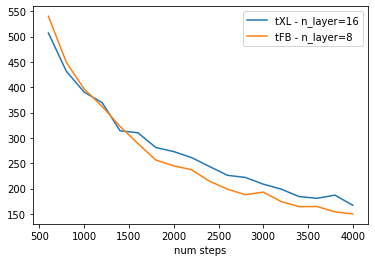

In [128]:
ax = xltransfo.plot('num steps', 'tXL - n_layer=16')
fbtransfo.plot('num steps', 'tFB - n_layer=8', ax=ax)